In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.image as mpimg
import numpy as np
import pickle
import tensorflow as tf
from tqdm import tqdm
from __future__ import division
import matplotlib.pyplot as plt

In [2]:
def text_plot(ax_, string, alpha, color, fontsize):
	delta = [(ax_.get_xlim()[1] - ax_.get_xlim()[0]), (ax_.get_ylim()[1] - ax_.get_ylim()[0])]
	xt = alpha[0] * delta[0] + ax_.get_xlim()[0]
	yt = alpha[1] * delta[1] + ax_.get_ylim()[0]    
	ax_.text(xt, yt, string, fontsize=fontsize,color=color)


def loadNPZ(pathNPZ):
    data = np.load(pathNPZ)
    trainX = data['trainX']
    trainY = data['trainY']
    testX = data['testX']
    testY = data['testY']
    label = data['label']
    
    return trainX, trainY, testX, testY, label

def S(bits):
    return 2.0 ** (bits - 1)

def Shift(x):
    return 2 ** tf.round(tf.log(x) / tf.log(2.0))

def Q(x, bits):
    if bits > 15:
        return x
    elif bits == 1:  # BNN
        return tf.sign(x)
    else:
        SCALE = S(bits)
        return tf.round(x * SCALE) / SCALE
    
def C(x, bits=32):
    if bits > 15 or bits == 1:
        delta = 0.
    else:
        delta = 1. / S(bits)
    MAX = +1 - delta
    MIN = -1 + delta
    x = tf.clip_by_value(x, MIN, MAX, name='saturate')
    return x

In [3]:
def _arr(stride_or_ksize):
    # data format NCHW
    return [1, 1, stride_or_ksize, stride_or_ksize]

def _get_variable(shape, name):
    initializer = myInitializer.variance_scaling_initializer(
      factor=1.0, mode='FAN_IN', uniform=True)
    
    with tf.name_scope(name) as scope:
        W.append(tf.get_variable(name=name, shape=shape, initializer=initializer))

        print('W:', W[-1].device, scope, shape,)
        if Quantize.bitsW <= 16:
            # manually clip and quantize W if needed
            W_q_op.append(tf.assign(W[-1], Quantize.Q(W[-1], Quantize.bitsW)))
            W_clip_op.append(tf.assign(W[-1],Quantize.C(W[-1],Quantize.bitsW)))
            scale = Option.W_scale[len(W)-1]
            print('Scale:%d' % scale)
            W_q.append(Quantize.W(W[-1], scale))
            return W_q[-1]
        else:
            print('')
            return W[-1]

    
def W(x, bitsW, scale = 1.0):
	with tf.name_scope('QW'):
		y = Q(C(x, bitsW), bitsW)
		# we scale W in QW rather than QA for simplicity
		if scale > 1.8:
			y = y/scale
		# if bitsG > 15:
		# when not quantize gradient, we should rescale the scale factor in backprop
		# otherwise the learning rate will have decay factor scale
		# x = x * scale
	return x + tf.stop_gradient(y - x)  # skip derivation of Quantize and Clip

def A(x, bitsA):
	with tf.name_scope('QA'):
		x = C(x, bitsA)
		y = Q(x, bitsA)
	return x + tf.stop_gradient(y - x)  # skip derivation of Quantize, but keep Clip

def G(x, LR, bitsG):
	bitsR = 16    
	with tf.name_scope('QG'):
		if bitsG > 15:
			return x
		else:
			if x.name.lower().find('batchnorm') > -1:
				return x  # batch norm parameters, not quantize now

			xmax = tf.reduce_max(tf.abs(x))
			x = x / Shift(xmax)

			norm = Q(LR * x, bitsR)
			norm_sign = tf.sign(norm)
			norm_abs = tf.abs(norm)
			norm_int = tf.floor(norm_abs)
			norm_float = norm_abs - norm_int
			rand_float = tf.random_uniform(x.get_shape(), 0, 1)
			norm = norm_sign * ( norm_int + 0.5 * (tf.sign(norm_float - rand_float) + 1) )

		return norm / S(bitsG)


# @tf.RegisterGradient('Error')
# def error(op, x):
# 	if bitsE > 15:
# 		return x
# 	else:
# 		xmax = tf.reduce_max(tf.abs(x))
# 		xmax_shift = Shift(xmax) # gamma = /8
# 		return Q(C( x /xmax_shift, bitsE), bitsE)

# def E(x):
# 	with tf.name_scope('QE'):
# 		with Graph.gradient_override_map({'Identity': 'Error'}):
# 			return tf.identity(x)

In [4]:
dataSet = 'CIFAR10'
pathNPZ = 'dataSet/' + dataSet + '.npz'
numpyTrainX, numpyTrainY, numpyTestX, numpyTestY, label = loadNPZ(pathNPZ)

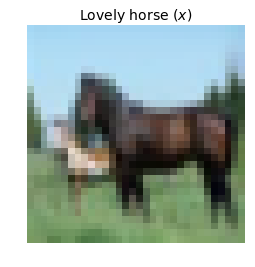

In [5]:
img = numpyTrainX[12]
# X = X / 127.5 - 1
plt.imshow(img)
plt.axis('off')
plt.title('Lovely horse ($x$)', fontsize=14)
imgs = img / 127.5 - 1

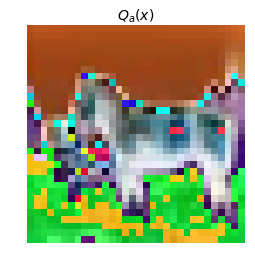

In [6]:
with tf.Session():
    imgsQA = A(imgs, 8).eval()

imgsQA = np.array(imgsQA)
plt.imshow((imgsQA+1)*127.5)
plt.axis('off')
plt.title('$Q_a(x)$', fontsize=14)
plt.show()


Standard deviations
w = 0.444157
w_q = 0.414578


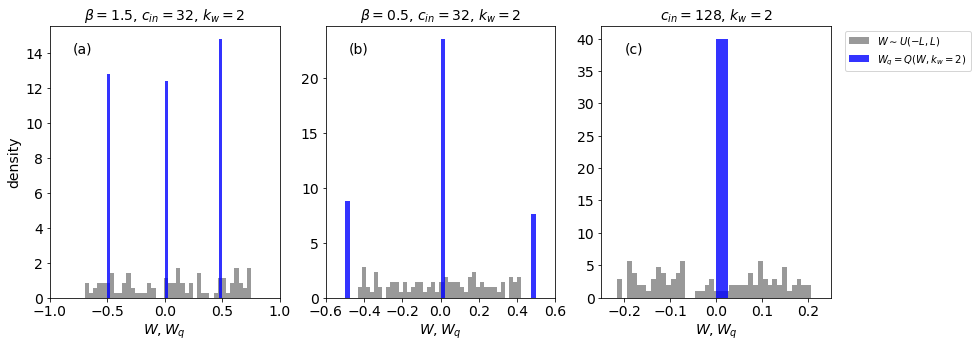

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(14,5))

c_in = 32
L_min = 1.5 / S(2)

L = np.max((np.sqrt(6/(c_in)), L_min))

w =  np.random.uniform(-L,L,100)
with tf.Session():
    wq = Q(C(w, 2),2).eval()

n, bins, patches = ax1.hist(w, bins=40, normed=1, facecolor='grey', alpha=0.8)
n, bins, patches = ax1.hist(wq, bins=40, normed=1, facecolor='blue', alpha=0.8)

print('Standard deviations')
print('===================')
print('w = {:4f}'.format(np.std(w)))
print('w_q = {:4f}'.format(np.std(wq)))

############

c_in = 32
L_min = 0.5 / S(2)
L = np.max((np.sqrt(6/(c_in)), L_min))
w =  np.random.uniform(-L,L,100)
with tf.Session():
    wq = Q(C(w, 2),2).eval()

n, bins, patches = ax2.hist(w, bins=40, normed=1, facecolor='grey', alpha=0.8)
n, bins, patches = ax2.hist(wq, bins=40, normed=1, facecolor='blue', alpha=0.8)

############

c_in = 128
L_min = 1.5 / S(2)
L = np.max((np.sqrt(6/(c_in))))
w =  np.random.uniform(-L,L,100)
with tf.Session():
    wq = Q(C(w, 2),2).eval()

n, bins, patches = ax3.hist(w, bins=40, normed=1, facecolor='grey', alpha=0.8)
n, bins, patches = ax3.hist(wq, bins=40, normed=1, facecolor='blue', alpha=0.8)

ax3.legend(('$W \sim U(-L, L)$', '$W_q = Q(W, k_w = 2)$'), bbox_to_anchor=(1.04,1))
# ax3.legend(bbox_to_anchor=(1.04,1))
ax1.set_xlabel('$W, W_q$')
ax2.set_xlabel('$W, W_q$')
ax3.set_xlabel('$W, W_q$')
ax1.set_ylabel('density')
ax1.set_title('$\\beta = 1.5$, $c_{in} = 32$, $k_w = 2$' )
ax2.set_title('$\\beta = 0.5$, $c_{in} = 32$, $k_w = 2$' )
ax3.set_title('$c_{in} = 128$, $k_w = 2$' )

ax1.set_xlim((-1, 1))
ax2.set_xlim((-0.6, 0.6))
ax3.set_xlim((-0.25, 0.25))

axis = [ax1, ax2, ax3]
strings = ['(a)', '(b)', '(c)']
for i, (ax, string) in enumerate(zip(axis, strings)):
    text_plot(ax, string, [0.1, 0.9], 'k', fontsize=14)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)




    
plt.show()
fig.savefig('figures/Qw.pdf', bbox_inches='tight')